# Predicting genetic disorder and disorder subclass based on familial history                                                        and its effects

### TEAM SIGMA

B Pravena - PES2UG19CS076

Lavanya Yavagal - PES2UG19CS904

Swarnamalya A S - PES2UG19CS418

Varna Satyanarayana - PES2UG19CS448

Importing all the necessary libraries and modules

In [291]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.manifold import Isomap,TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

Load the train and test datasets into the pandas dataframe

In [292]:
df_train=pd.read_csv('/Users/swarna/Swarnaa/DataAnalytics/train.csv')
df_test=pd.read_csv('/Users/swarna/Swarnaa/DataAnalytics/test.csv')
df_train.head()

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


Dropping the unnecessary columns

In [293]:
df_train.drop("Patient Id",axis=1,inplace=True)
df_train.drop("Family Name",axis=1,inplace=True)
df_train.drop("Patient First Name",axis=1,inplace=True)
df_train.drop("Father's name",axis=1,inplace=True)
df_train.drop("Institute Name",axis=1,inplace=True)
df_train.drop("Location of Institute",axis=1,inplace=True)
df_train.drop("Place of birth",axis=1,inplace=True)
df_train.drop("Parental consent",axis=1,inplace=True)
df_train.drop("Follow-up",axis=1,inplace=True)

df_test.drop("Patient Id",axis=1,inplace=True)
df_test.drop("Family Name",axis=1,inplace=True)
df_test.drop("Patient First Name",axis=1,inplace=True)
df_test.drop("Father's name",axis=1,inplace=True)
df_test.drop("Institute Name",axis=1,inplace=True)
df_test.drop("Location of Institute",axis=1,inplace=True)
df_test.drop("Place of birth",axis=1,inplace=True)
df_test.drop("Parental consent",axis=1,inplace=True)
df_test.drop("Follow-up",axis=1,inplace=True)

Counting the number of Nan values in each column

In [294]:
df_train.isna().sum()

Patient Age                                         1427
Genes in mother's side                                 0
Inherited from father                                306
Maternal gene                                       2810
Paternal gene                                          0
Blood cell count (mcL)                                 0
Mother's age                                        6036
Father's age                                        5986
Status                                                 0
Respiratory Rate (breaths/min)                      2149
Heart Rate (rates/min                               2113
Test 1                                              2127
Test 2                                              2152
Test 3                                              2147
Test 4                                              2140
Test 5                                              2170
Gender                                              2173
Birth asphyxia                 

### Filling Nan values
Replacing the Nan values appropriately with the mode for categorical data and mean for continuous data after grouping the data by 'Genetic Disorder' and 'Disorder Subclass'

In [295]:
catecols=["Genes in mother's side", "Inherited from father", 'Maternal gene',
       'Paternal gene', 'Status','Gender',
       'Respiratory Rate (breaths/min)', 'Heart Rate (rates/min','Birth asphyxia',
       'Autopsy shows birth defect (if applicable)','Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)', 'H/O substance abuse',
       'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies','Birth defects', 'Blood test result']   

x=df_train.groupby('Genetic Disorder')['Disorder Subclass'].apply(set)
y=dict(x)
df_train = df_train[df_train['Disorder Subclass'].notna()]

d={}
for i in range(len(x)):
  x[i]=list(x[i])
  for j in x[i]:
    d[j]=x.index[i]

disorder=d

import math
df_train['Genetic Disorder'] = df_train.apply(
    lambda row: disorder[row['Disorder Subclass']] if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)

f = lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
df_train = df_train.fillna(df_train.groupby(['Disorder Subclass']).transform(f))

#Deep copy the train dataset into another dataframe
dfg=df_train.copy(deep=True)

df_train

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Mother's age,Father's age,Status,Respiratory Rate (breaths/min),...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,2.0,Yes,No,Yes,No,4.760603,34.978814,42.159184,Alive,Normal (30-60),...,Multiple,9.857562,slightly abnormal,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,4.0,Yes,Yes,No,No,4.910669,34.661983,23.0,Deceased,Tachypnea,...,Multiple,5.52256,normal,1.0,0.701726,1.0,1.0,0.0,Single-gene inheritance diseases,Cystic fibrosis
2,6.0,Yes,No,No,No,4.893297,41.0,22.0,Alive,Normal (30-60),...,Singular,7.472702,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,12.0,Yes,No,Yes,No,4.70528,21.0,41.689446,Deceased,Tachypnea,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,11.0,Yes,No,No,Yes,4.720703,32.0,40.971429,Alive,Tachypnea,...,Multiple,4.09821,abnormal,0.0,0.0,0.0,0.0,0.011494,Multifactorial genetic inheritance disorders,Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22078,4.0,Yes,Yes,Yes,No,5.258298,35.0,64.0,Deceased,Normal (30-60),...,Multiple,6.584811,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
22079,8.0,No,Yes,No,Yes,4.97422,34.684094,56.0,Alive,Normal (30-60),...,Multiple,7.041556,inconclusive,1.0,1.0,1.0,1.0,0.0,Multifactorial genetic inheritance disorders,Diabetes
22080,8.0,Yes,No,Yes,No,5.18647,35.0,51.0,Deceased,Tachypnea,...,Singular,7.715464,normal,0.0,0.0,0.0,1.0,0.321241,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy
22081,7.0,Yes,No,Yes,Yes,4.858543,19.0,41.689446,Alive,Tachypnea,...,Multiple,8.43767,abnormal,1.0,1.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome


In [296]:
for i in df_train.columns:
    print(i,df_train[i].unique())

Patient Age [2.0 4.0 6.0 12.0 11.0 14.0 3.0 7.0 1.0 0.0 6.950728230554695 10.0
 6.936245083833575 5.0 7.095345345345345 8.0 9.0 13.0 6.871749408983452
 6.784539473684211 6.9524384355383875 6.875394321766562 6.554054054054054
 7.413043478260869]
Genes in mother's side ['Yes' 'No']
Inherited from father ['No' 'Yes']
Maternal gene ['Yes' 'No']
Paternal gene ['No' 'Yes']
Blood cell count (mcL) [4.760603085632425 4.910669059571037 4.8932974275730095 ...
 5.186470200960933 4.858542665533117 4.738066707058387]
Mother's age [34.978813559322035 34.66198282591725 41.0 21.0 32.0 34.469839773798306
 40.0 45.0 44.0 34.495486459378135 50.0 28.0 30.0 24.0 36.0
 34.453417788334654 34.47402597402598 51.0 23.0 49.0 46.0 18.0 38.0 37.0
 42.0 48.0 25.0 19.0 47.0 34.0 35.0 22.0 33.0 20.0 26.0 29.0 31.0 27.0
 43.0 39.0 34.55263157894737 35.293577981651374 34.68409425625921]
Father's age [42.159183673469386 23.0 22.0 41.68944591029024 40.97142857142857
 42.04525946156848 63.0 42.07037565382787 44.0 42.0 42.0

### Filling Nan values in test dataset

In [297]:
df_test=df_test.replace(' ',None)
testf= {'Patient Age': 4.0, "Genes in mother's side": 'Yes', 'Inherited from father': 'No', 'Maternal gene': 'Yes', 'Paternal gene': 'No', 'Blood cell count (mcL)': 4.898916949522597, "Mother's age": '23.0', "Father's age": '20.0', 'Respiratory Rate (breaths/min)': 'Normal (30-60)', 'Heart Rate (rates/min': 'Normal', 'Test 1': 0.0, 'Test 2': 0.0, 'Test 3': 0.0, 'Test 4': 1.0, 'Test 5': 0.0, 'Parental consent': 'Yes', 'Follow-up': 'Low', 'Gender': 'Ambiguous', 'Birth asphyxia': 'Yes', 'Autopsy shows birth defect (if applicable)': 'Not applicable', 'Folic acid details (peri-conceptional)': 'Yes', 'H/O serious maternal illness': 'No', 'H/O radiation exposure (x-ray)': 'Not applicable', 'H/O substance abuse': '-', 'Assisted conception IVF/ART': 'Yes', 'History of anomalies in previous pregnancies': 'Yes', 'No. of previous abortion': 2.0, 'Birth defects': 'Singular', 'White Blood cell count (thousand per microliter)': '7.486223987209439', 'Blood test result': 'slightly abnormal', 'Symptom 1': 1.0, 'Symptom 2': 1.0, 'Symptom 3': 1.0, 'Symptom 4': 0.0, 'Symptom 5': 0.0}
df_test=df_test.fillna(value=testf)

In [298]:
df_test

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Mother's age,Father's age,Status,Respiratory Rate (breaths/min),...,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
0,6,No,Yes,No,No,4.981655,38,61,Alive,Tachypnea,...,Yes,2,Multiple,0.000000,slightly abnormal,True,True,True,True,True
1,10,Yes,No,Yes,Yes,5.118890,33,53,Alive,Normal (30-60),...,Yes,2.0,Multiple,8.179584,normal,False,False,False,True,False
2,5,No,No,No,No,4.876204,48,60,Deceased,Normal (30-60),...,No,0,Singular,0.000000,slightly abnormal,False,False,True,True,False
3,13,No,Yes,Yes,No,4.687767,25,55,Alive,Normal (30-60),...,Yes,2.0,Singular,6.884071,normal,True,False,True,False,True
4,5,No,No,Yes,Yes,5.152362,41,38,Deceased,Tachypnea,...,No,2.0,Multiple,6.195178,normal,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,9,Yes,Yes,Yes,No,4.878335,28,63,Alive,Normal (30-60),...,Yes,2,Multiple,7.234960,abnormal,False,True,True,True,False
9461,1,Yes,No,Yes,Yes,4.927151,37,62,Deceased,Normal (30-60),...,No,2,Singular,4.859536,abnormal,False,True,False,True,True
9462,2,No,Yes,No,No,4.898352,24,32,Deceased,Tachypnea,...,No,3,Singular,5.696062,normal,False,True,False,False,True
9463,13,No,Yes,No,No,4.804840,36,56,Alive,Normal (30-60),...,No,1,Singular,3.000000,inconclusive,True,True,True,True,True


In [299]:
df_train.isna().sum()

Patient Age                                         0
Genes in mother's side                              0
Inherited from father                               0
Maternal gene                                       0
Paternal gene                                       0
Blood cell count (mcL)                              0
Mother's age                                        0
Father's age                                        0
Status                                              0
Respiratory Rate (breaths/min)                      0
Heart Rate (rates/min                               0
Test 1                                              0
Test 2                                              0
Test 3                                              0
Test 4                                              0
Test 5                                              0
Gender                                              0
Birth asphyxia                                      0
Autopsy shows birth defect (

In [300]:
df_test.isna().sum()

Patient Age                                         0
Genes in mother's side                              0
Inherited from father                               0
Maternal gene                                       0
Paternal gene                                       0
Blood cell count (mcL)                              0
Mother's age                                        0
Father's age                                        0
Status                                              0
Respiratory Rate (breaths/min)                      0
Heart Rate (rates/min                               0
Test 1                                              0
Test 2                                              0
Test 3                                              0
Test 4                                              0
Test 5                                              0
Gender                                              0
Birth asphyxia                                      0
Autopsy shows birth defect (

# Correlation
### Chi Square Test

In [208]:
train=df_train
df=train
df=df.apply(lambda x : pd.factorize(x)[0])+1
resultant = pd.DataFrame(data=[(0 for i in range(len(df.columns))) for i in range(len(df.columns))], 
                         columns=list(df.columns))
resultant.set_index(pd.Index(list(df.columns)), inplace = True)
from sklearn.feature_selection import chi2
for i in list(df.columns):
    for j in list(df.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
            resultant.loc[i,j] = p_val
print(resultant)

                                                    Patient Age  \
Patient Age                                        0.000000e+00   
Genes in mother's side                             9.709372e-01   
Inherited from father                              9.424856e-01   
Maternal gene                                      2.843572e-01   
Paternal gene                                      9.881866e-01   
Blood cell count (mcL)                             0.000000e+00   
Mother's age                                      1.588963e-261   
Father's age                                       0.000000e+00   
Status                                             9.999892e-01   
Respiratory Rate (breaths/min)                     9.947021e-01   
Heart Rate (rates/min                              9.921153e-01   
Test 1                                             1.000000e+00   
Test 2                                             1.000000e+00   
Test 3                                             1.000000e+0

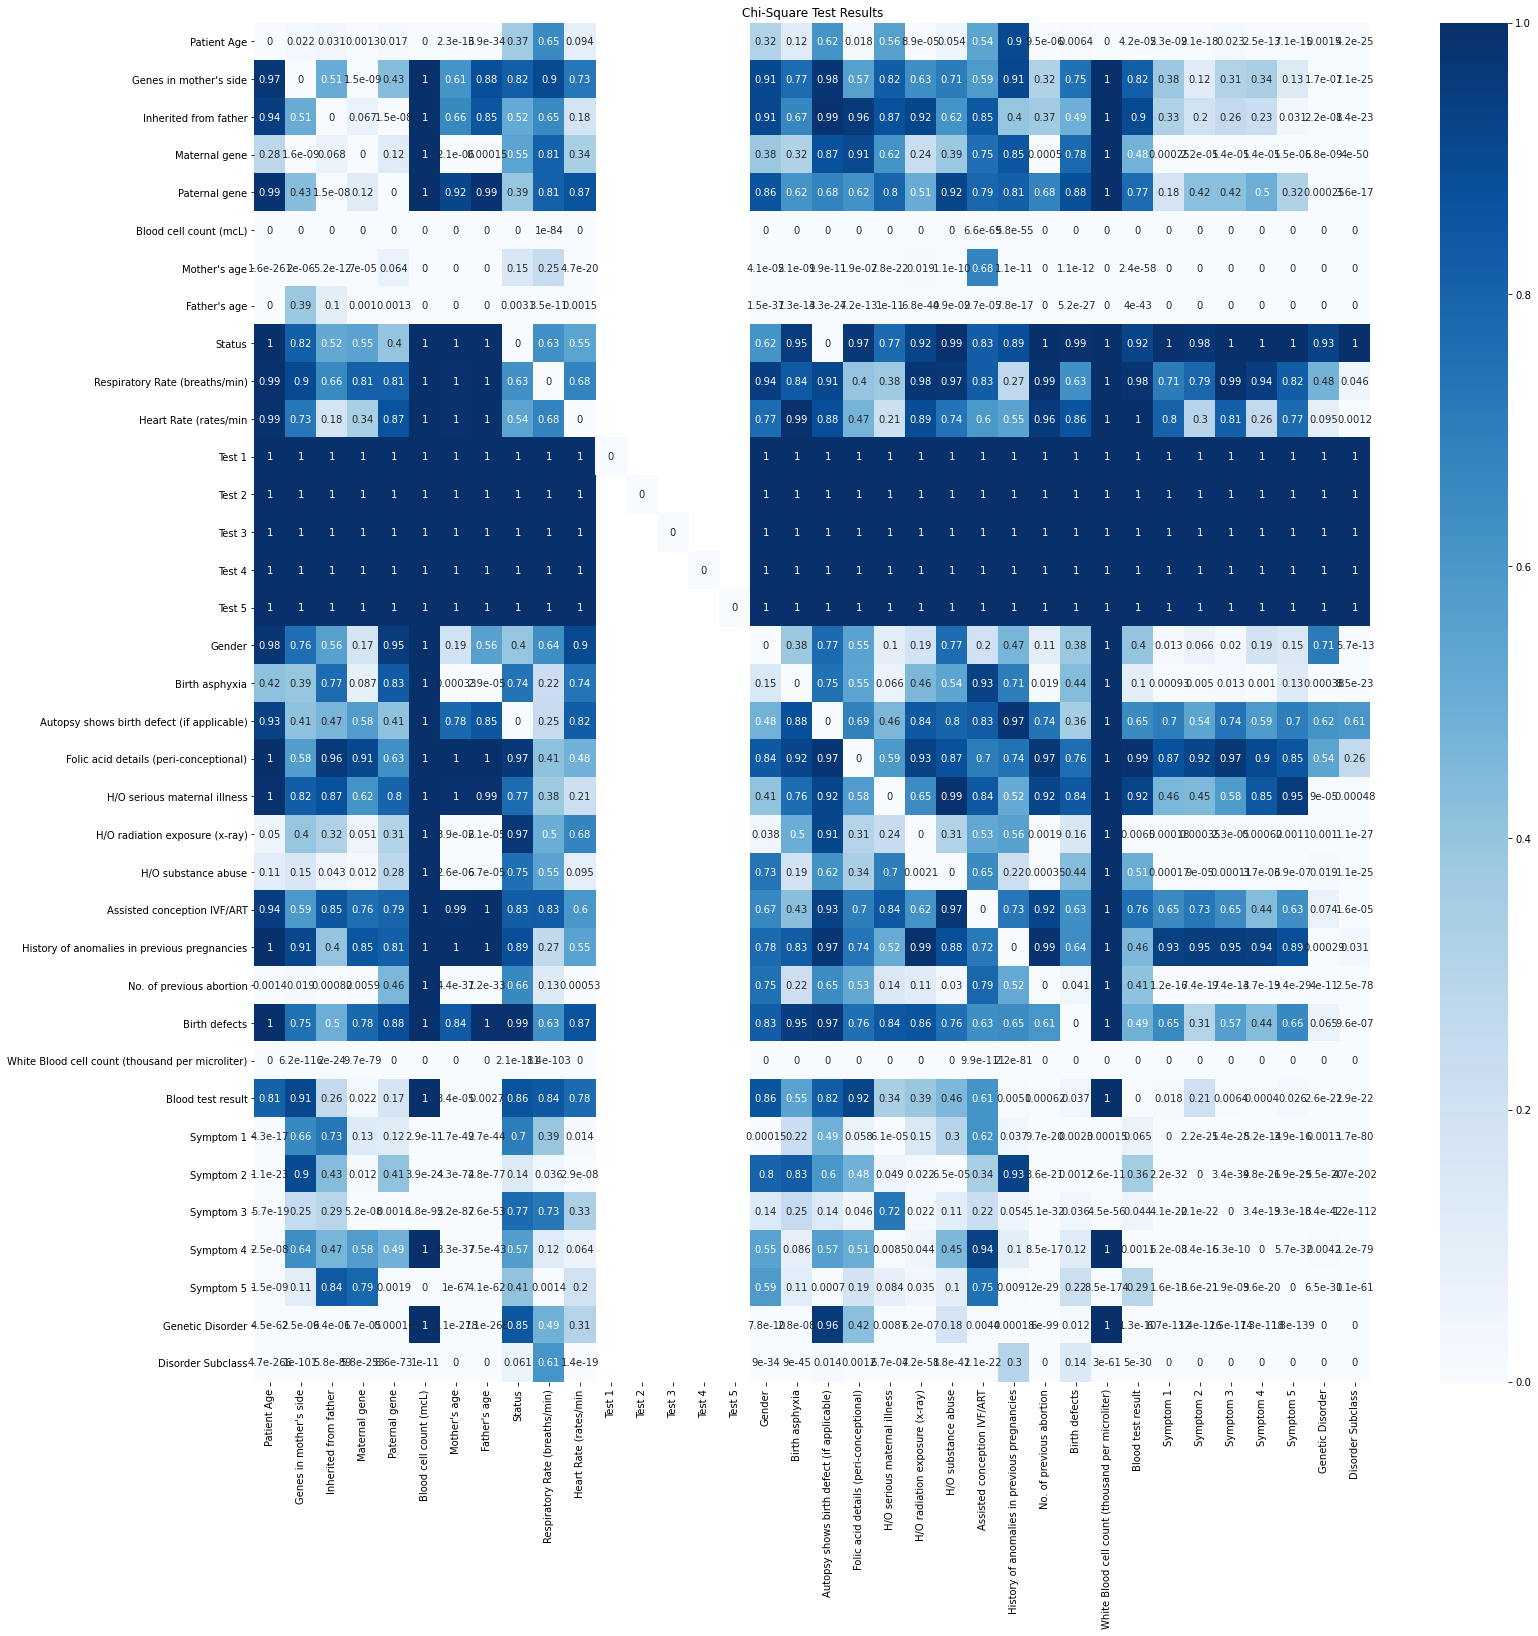

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(25,25))
sns.heatmap(resultant, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.show()

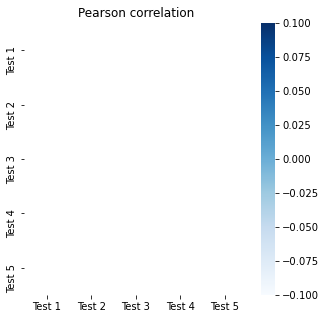

In [112]:
fig = plt.figure(figsize=(5,5))
sns.heatmap(train.corr(), annot=True, cmap='Blues')
plt.title('Pearson correlation')
plt.show()

# Handling Outliers

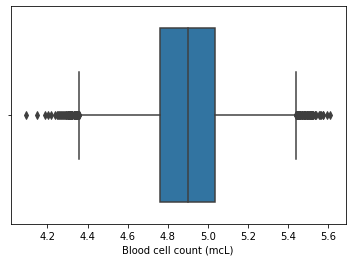

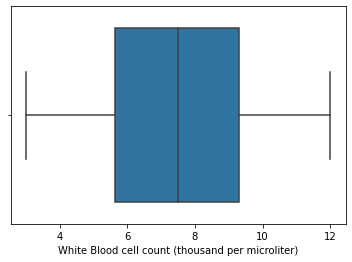

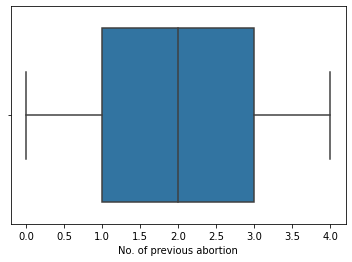

In [113]:
import matplotlib.pyplot as plt
for i in ('Blood cell count (mcL)','White Blood cell count (thousand per microliter)','No. of previous abortion'):
    sns.boxplot(x=train[i])
    plt.show()
    plt.clf()
    plt.close()

In [114]:
print('Outliers:')
for i in ('Blood cell count (mcL)','White Blood cell count (thousand per microliter)','No. of previous abortion'):
    Q1 = train[i].quantile(0.25)
    Q3 = train[i].quantile(0.75)
    IQR = Q3 - Q1
    print(i,'-',((train[i] < (Q1 - 1.5 * IQR)) | (train[i] > (Q3 + 1.5 * IQR))).sum())

Outliers:
Blood cell count (mcL) - 134
White Blood cell count (thousand per microliter) - 0
No. of previous abortion - 0


# Predicting the Disorder Subclass
1. Without Considering Genetic Disorder as a feature 
2. Considering Genetic Disorder as a feature

## 1. Without Considering Genetic Disorder as a feature

In [301]:
df_train.drop("Genetic Disorder",axis=1,inplace=True)

In [302]:
#Leber's hereditary optic neuropathy:1 
#Cystic fibrosis:0
#Diabetes:2
#Leigh syndrome:3
#Cancer:4
#Tay-Sachs:5
#Hemochromatosis:6
#Mitochondrial myopathy:7
#Alzheimer's:8
df_train["Disorder Subclass"]=[1 if i.strip()== "Leber's hereditary optic neuropathy" 
                                else 0 if i.strip() == "Cystic fibrosis" 
                               else 2 if i.strip()=="Diabetes" 
                               else 3 if i.strip()=="Leigh syndrome"
                               else 4 if i.strip()=="Cancer"
                               else 5 if i.strip()=="Tay-Sachs"
                               else 6 if i.strip()=="Hemochromatosis"
                               else 7 if i.strip()=="Mitochondrial myopathy"
                               else 8 for i in df_train["Disorder Subclass"]]



### Converting Categorical Data using One Hot Encoding

In [303]:
#One Hot Encoding 
catecols=["Genes in mother's side", "Inherited from father", 'Maternal gene',
       'Paternal gene','Respiratory Rate (breaths/min)','Heart Rate (rates/min','Birth asphyxia',
       'Autopsy shows birth defect (if applicable)','Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)', 'H/O substance abuse','Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies','Birth defects','Blood test result','Status','Gender']

one_hot_encoded_data = pd.get_dummies(df_train, columns = catecols)

df_train=one_hot_encoded_data
df_train

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,...,Birth defects_Singular,Blood test result_abnormal,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal,Status_Alive,Status_Deceased,Gender_Ambiguous,Gender_Female,Gender_Male
0,2.0,4.760603,34.978814,42.159184,0,0,0,1,0,1.971039,...,0,0,0,0,1,1,0,0,0,1
1,4.0,4.910669,34.661983,23.0,0,0,0,1,0,2.01242,...,0,0,0,1,0,0,1,1,0,0
2,6.0,4.893297,41.0,22.0,0,0,0,1,0,4.0,...,1,0,0,1,0,1,0,1,0,0
3,12.0,4.70528,21.0,41.689446,0,0,0,1,0,1.0,...,1,0,1,0,0,0,1,0,0,1
4,11.0,4.720703,32.0,40.971429,0,0,0,1,0,4.0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22078,4.0,5.258298,35.0,64.0,0,0,0,1,0,3.0,...,0,0,1,0,0,0,1,0,1,0
22079,8.0,4.97422,34.684094,56.0,0,0,0,1,0,2.0,...,0,0,1,0,0,1,0,1,0,0
22080,8.0,5.18647,35.0,51.0,0,0,0,1,0,2.0,...,1,0,0,1,0,0,1,0,0,1
22081,7.0,4.858543,19.0,41.689446,0,0,0,1,0,1.0,...,0,1,0,0,0,1,0,0,0,1


In [304]:
df_train = df_train.apply(pd.to_numeric,downcast="float")

### Averaging the Age, Symptom and Test features

In [305]:
df_train["sum of Mother's and fathers age avg"]=(df_train["Mother's age"]+df_train["Father's age"]) / 2
df_train["total symptom"]=(df_train["Symptom 1"]+df_train["Symptom 2"]+df_train["Symptom 3"]+df_train["Symptom 4"]+df_train["Symptom 5"]) / 5
df_train["total test"]=(df_train["Test 1"]+df_train["Test 2"]+df_train["Test 3"]+df_train["Test 4"]+df_train["Test 5"])

### Splitting the dataset into Train, Test and Validation Sets

In [306]:
cols_names=['Blood cell count (mcL)','White Blood cell count (thousand per microliter)','No. of previous abortion']

x,y = df_train.loc[:,df_train.columns != 'Disorder Subclass'], df_train.loc[:,'Disorder Subclass']

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


### Normalizing the dataset using MinMaxScalar

In [307]:
sc = MinMaxScaler()
x_train = sc.fit_transform(X_train[cols_names])  
x_test = sc.transform(X_test[cols_names])  
x_val = sc.transform(X_val[cols_names])  

X_test[cols_names]=x_test
X_train[cols_names]=x_train
X_val[cols_names]=x_val

# Predicting the Disorder Subclass using various models

### GradientBoosting Classifier

In [216]:
gbmc_m = GradientBoostingClassifier(verbose=False,learning_rate = 0.15, random_state=35).fit(X_train,y_train)

predict = gbmc_m.predict(X_val)

print("ACC-->",accuracy_score(y_val,predict))

ACC--> 0.7532011046949536


### XGBoost Classifier

In [16]:
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.3,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_val)

print("ACC-->",accuracy_score(y_val,preds))


[01:32:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ACC--> 0.7105197087622395


### Bagging Regressor

In [351]:
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())

model.fit(X_train, y_train)

pred = model.predict(X_val)

print(model.score(X_val,y_val))

0.7303090908228078


### Run a baseline GradientBoostingClassifier model without tuning

Accuracy of the GBM on test set: 0.734
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75       690
         1.0       0.73      0.53      0.61       114
         2.0       0.69      0.70      0.70       352
         3.0       0.72      0.80      0.76      1030
         4.0       0.80      0.24      0.36        17
         5.0       0.72      0.73      0.72       561
         6.0       0.77      0.65      0.71       276
         7.0       0.76      0.74      0.75       912
         8.0       0.82      0.29      0.43        31

    accuracy                           0.73      3983
   macro avg       0.75      0.60      0.64      3983
weighted avg       0.74      0.73      0.73      3983



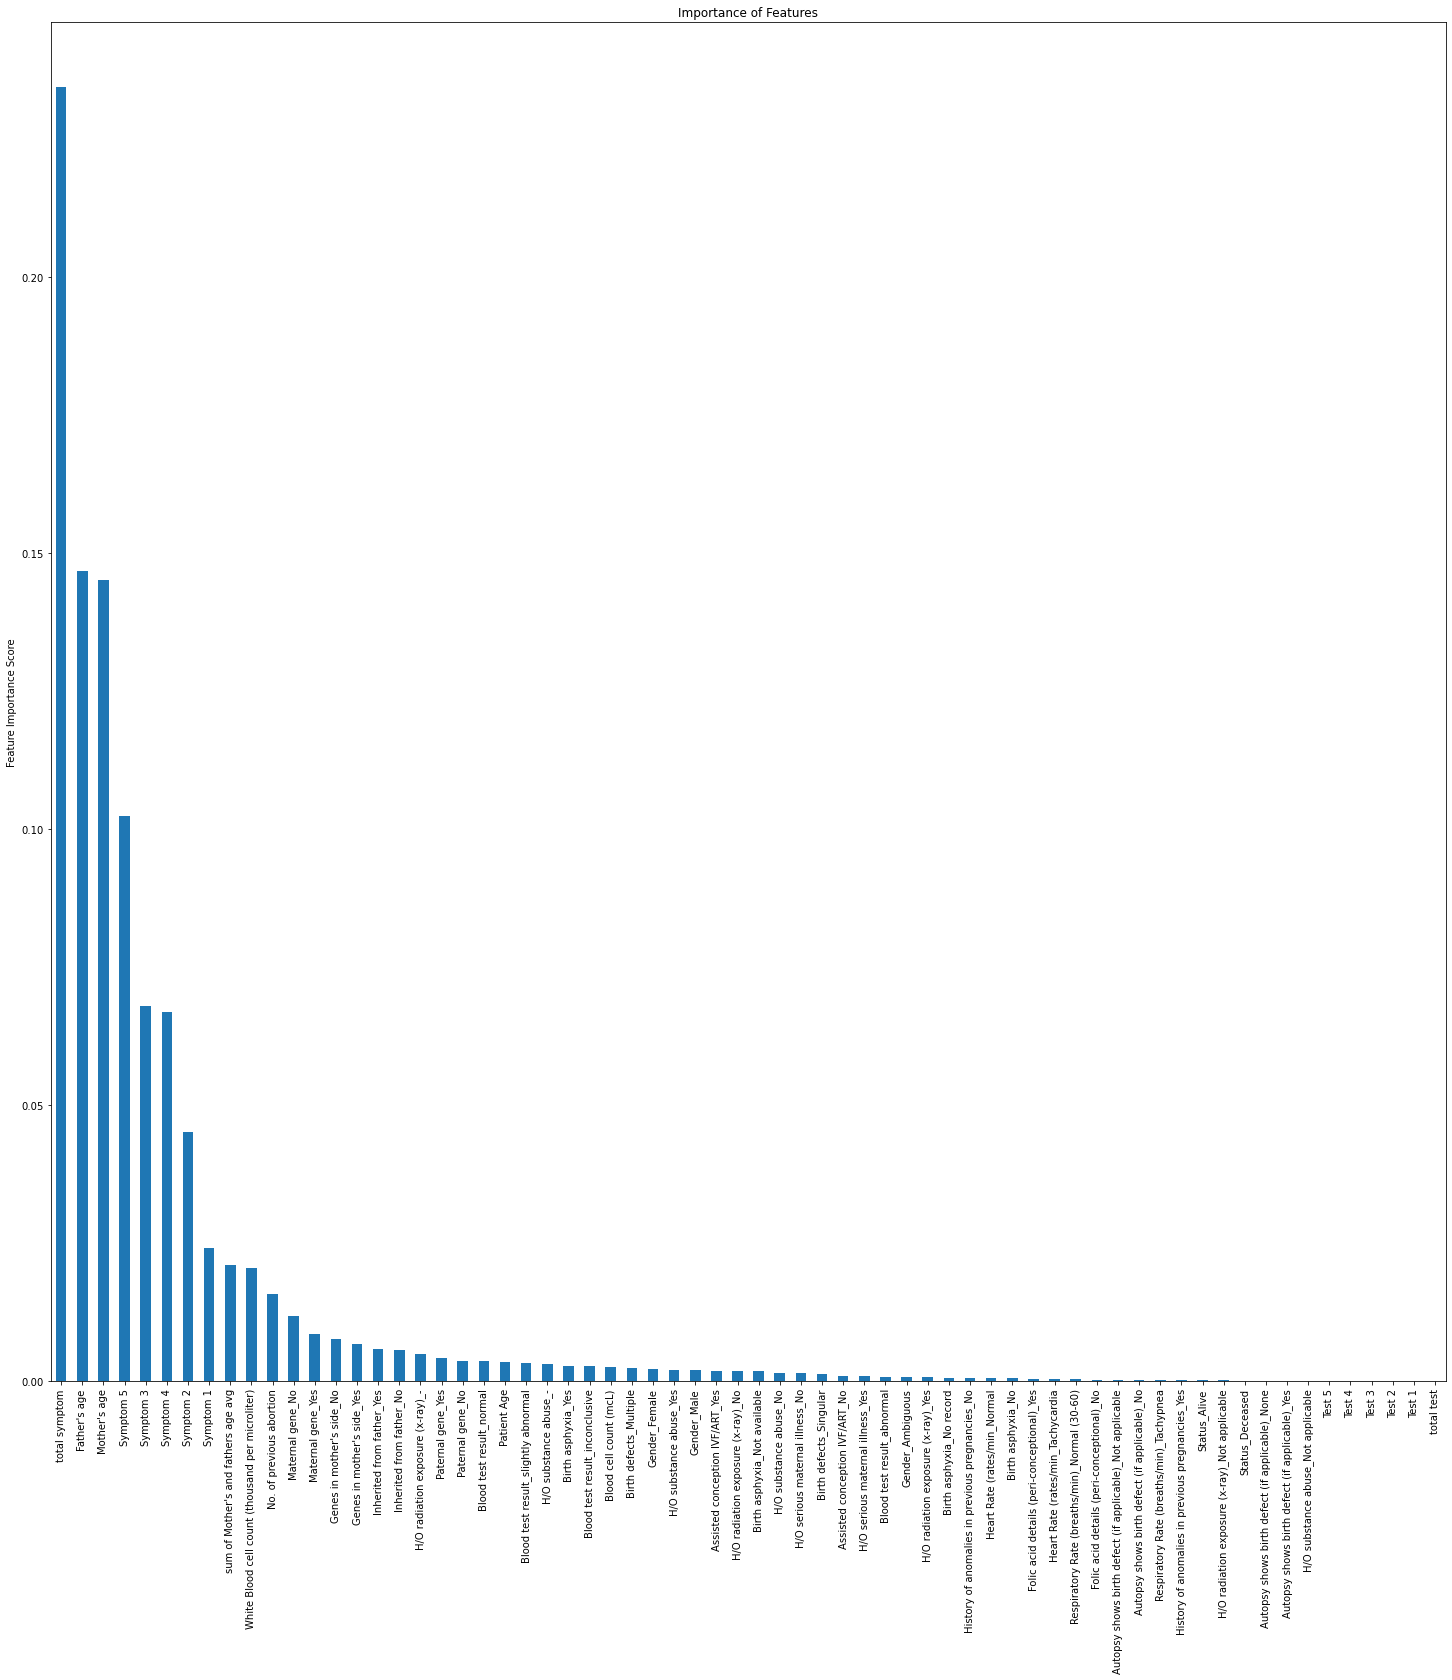

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(25,25))
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test ,pred))

### Tuning learning rate and n_estimators

In [80]:
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4, cv=3)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([ 5.20457037, 12.98215397, 25.65977502, 38.40298557, 51.41562835,
         63.74471434, 77.79208326,  5.17239896, 13.07213744, 26.97336396,
         38.83908025, 51.65453172, 64.49938361, 77.64115071,  5.26865196,
         13.16733726, 25.95628659, 39.17691406, 51.91159654, 64.66575535,
         77.55651601,  5.21380536, 13.22273604, 25.97595477, 38.74439557,
         51.77748871, 65.25501752, 78.26893449,  5.20632092, 12.98870643,
         25.79557498, 38.68901332, 52.00475295, 64.84410111, 78.39012472,
          5.2731204 , 13.22551696, 26.32572166, 39.85474674, 52.53741924,
         64.94374943, 77.23671333]),
  'std_fit_time': array([0.00468578, 0.0363497 , 0.06753676, 0.06348559, 0.14625437,
         0.26943724, 0.8935955 , 0.02967301, 0.09043247, 0.39160544,
         0.02048986, 0.15976282, 0.0662642 , 0.09447833, 0.08126932,
         0.10673354, 0.09640053, 0.0445979 , 0.25036267, 0.17813538,
         0.12940261, 0.07520506, 0.06595397, 0.01659135, 0.016

### Tuning Max Depth

In [81]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1500, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,cv=3)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([ 49.75834672,  63.94058577,  78.0998536 ,  94.35748831,
         113.81664928, 137.14688929]),
  'std_fit_time': array([0.01342788, 0.22582356, 0.10752144, 0.0648783 , 0.22276541,
         2.67016849]),
  'mean_score_time': array([0.73539901, 0.98583031, 1.27576454, 1.61437805, 2.00279268,
         2.33376296]),
  'std_score_time': array([0.00322155, 0.01134077, 0.01451601, 0.00879567, 0.00495532,
         0.06803071]),
  'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 2},
   {'max_depth': 3},
   {'max_depth': 4},
   {'max_depth': 5},
   {'max_depth': 6},
   {'max_depth': 7}],
  'split0_test_score': array([0.71704745, 0.73713281, 0.74391162, 0.74265629, 0.73813708,
         0.730354  ]),
  'split1_test_score': array([0.72307306, 0.7501883 , 0.75295004, 0.7501883 , 0.74366056,
         0.74165202]),
  'split2_

### First evaluation of new model

Accuracy of the GBM on test set: 0.759
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77       690
         1.0       0.69      0.52      0.59       114
         2.0       0.71      0.72      0.72       352
         3.0       0.77      0.81      0.79      1030
         4.0       0.80      0.24      0.36        17
         5.0       0.74      0.75      0.75       561
         6.0       0.79      0.70      0.74       276
         7.0       0.77      0.77      0.77       912
         8.0       0.86      0.39      0.53        31

    accuracy                           0.76      3983
   macro avg       0.77      0.63      0.67      3983
weighted avg       0.76      0.76      0.76      3983



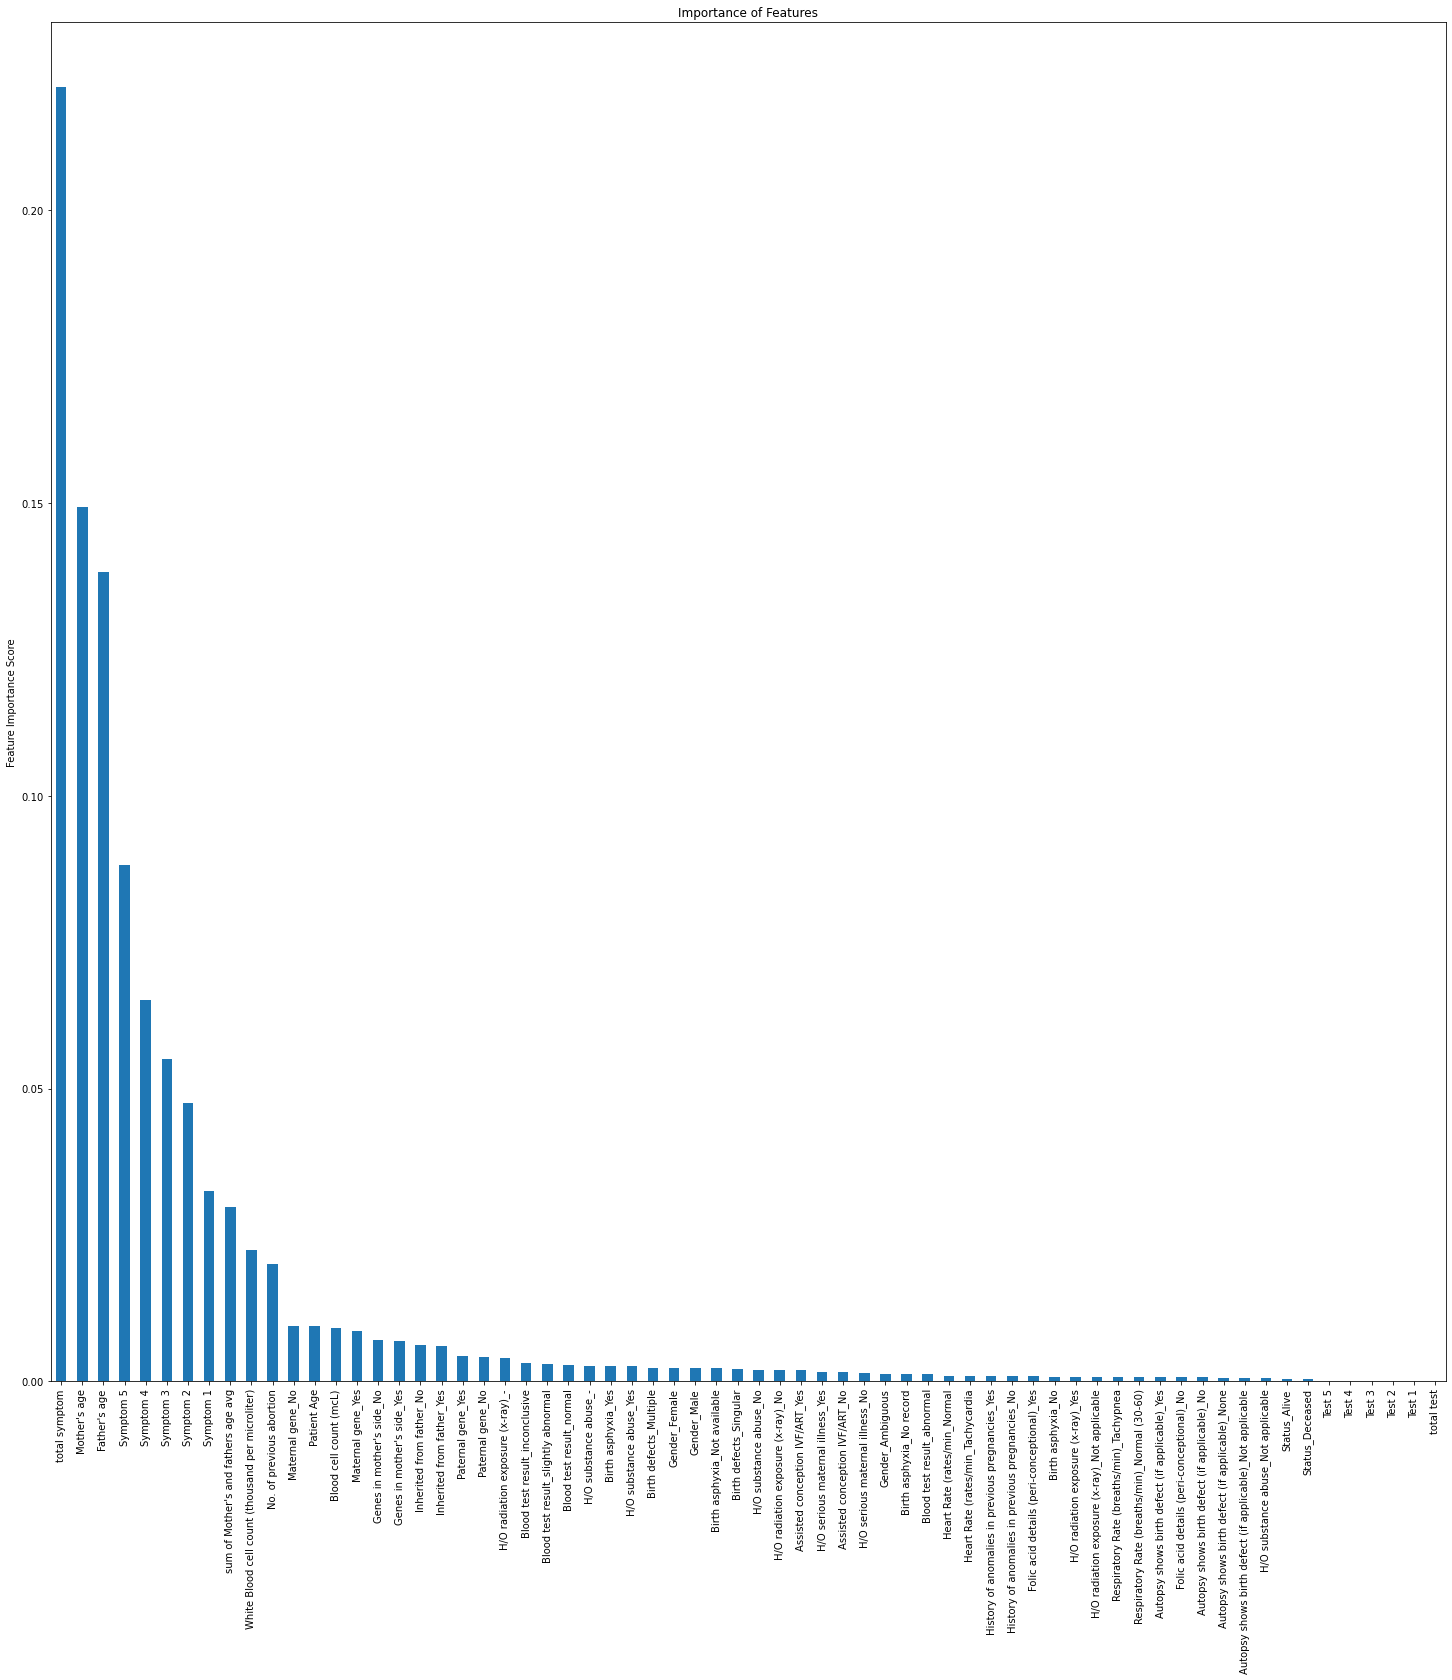

In [82]:
import matplotlib.pyplot as plt
model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(25,25))
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(X_test, y_test)))
pred=model1.predict(X_test)
print(classification_report(y_test, pred))

### Gradient Boosting Classifier with Cross Validation (k=10)

In [86]:
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
kfold = model_selection.KFold(n_splits=10)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 74.84% (0.92%)


### Ensemble Model with k-fold crossvalidation (k=10)

In [352]:
from sklearn.ensemble import VotingClassifier

kfold = model_selection.KFold(n_splits=10)

model_1 = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.3,max_depth = 5, alpha = 10, n_estimators = 10)
model_2 = GradientBoostingClassifier(verbose=False,learning_rate = 0.15)

final_model = VotingClassifier(estimators=[ ('xgb', model_1), ('gb', model_2)])
 
# training all the model on the train dataset
final_model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = final_model.predict(X_val)

score = final_model.score(X_val, y_val)
print('Accuracy Score: ', score)

classification_report(y_val, pred_final)
print(classification_report)

accuracy = accuracy_score(y_val, pred_final)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = model_selection.cross_val_score(final_model, X_train, y_train, cv=kfold)
print(results.mean())

[00:59:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score:  0.7358774792869697
<function classification_report at 0x7faae843c790>
Accuracy: 73.59%
[01:00:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:00:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost

### Ensemble Model with Cross Validation and Hyperparameter Tuning

In [56]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

model_1 = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.3,max_depth = 5, alpha = 10, n_estimators = 10)
model_2 = GradientBoostingClassifier(verbose=False,learning_rate = 0.15)

final_model = VotingClassifier(estimators=[ ('xgb', model_1), ('gb', model_2)])
cvm = cross_val_score(final_model, X_train, y_train)
base_score = cvm.mean()
base_std = cvm.std()
print('\n')
print(f'The average base cross-validation score is {round(base_score,4)} (+- {round(base_std,4)})')

params = {'voting':['hard', 'soft'],
          'weights':[(1,1), (2,1), 
                     (1,2), (1,1),
                     (1,1), (1,1), 
                     (1,1), (2,1)]}

#fit gridsearch & print best params
grid = GridSearchCV(final_model, params)
grid.fit(X_train, y_train)
print('\n')
print(f'The best params is : {grid.best_params_}')

#print the final cv score
tuned_vc = VotingClassifier([('xgb', model_1),('gb', model_2)], 
                             **grid.best_params_, n_jobs = -1)
tuned_cvm = cross_val_score(tuned_vc, X_train, y_train)
tuned_score = tuned_cvm.mean()
tuned_std = tuned_cvm.std()
print('\n')
print(f'The average tuned cross-validation score is {round(tuned_score, 4)} (+- {round(tuned_std, 4)})')


[11:31:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

# 2.Considering Genetic Disorder as a feature 

In [87]:
df_train=dfg
dfg.columns

Index(['Patient Age', 'Genes in mother's side', 'Inherited from father',
       'Maternal gene', 'Paternal gene', 'Blood cell count (mcL)',
       'Mother's age', 'Father's age', 'Status',
       'Respiratory Rate (breaths/min)', 'Heart Rate (rates/min', 'Test 1',
       'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Gender', 'Birth asphyxia',
       'Autopsy shows birth defect (if applicable)',
       'Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)',
       'H/O substance abuse', 'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies',
       'No. of previous abortion', 'Birth defects',
       'White Blood cell count (thousand per microliter)', 'Blood test result',
       'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5',
       'Genetic Disorder', 'Disorder Subclass'],
      dtype='object')

In [88]:
#Leber's hereditary optic neuropathy:1 
#Cystic fibrosis:0
#Diabetes:2
#Leigh syndrome:3
#Cancer:4
#Tay-Sachs:5
#Hemochromatosis:6
#Mitochondrial myopathy:7
#Alzheimer's:8

df_train["Disorder Subclass"]=[1 if i.strip()== "Leber's hereditary optic neuropathy" 
                                else 0 if i.strip() == "Cystic fibrosis" 
                               else 2 if i.strip()=="Diabetes" 
                               else 3 if i.strip()=="Leigh syndrome"
                               else 4 if i.strip()=="Cancer"
                               else 5 if i.strip()=="Tay-Sachs"
                               else 6 if i.strip()=="Hemochromatosis"
                               else 7 if i.strip()=="Mitochondrial myopathy"
                               else 8 for i in df_train["Disorder Subclass"]]



### Converting Categorical Data using One Hot Encoding

In [89]:
catecols=["Genes in mother's side", "Inherited from father", 'Maternal gene',
       'Paternal gene', 'Genetic Disorder',
       'Respiratory Rate (breaths/min)','Heart Rate (rates/min','Birth asphyxia',
       'Autopsy shows birth defect (if applicable)','Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)', 'H/O substance abuse',
       'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies','Birth defects', 'Blood test result','Status','Gender']

one_hot_encoded_data = pd.get_dummies(df_train, columns = catecols)

df_train=one_hot_encoded_data

In [90]:
df_train = df_train.apply(pd.to_numeric,downcast="float")

### Averaging the Age, Symptom and Test features

In [91]:
df_train["sum of Mother's and fathers age avg"]=(df_train["Mother's age"]+df_train["Father's age"]) / 2
df_train["total symptom"]=(df_train["Symptom 1"]+df_train["Symptom 2"]+df_train["Symptom 3"]+df_train["Symptom 4"]+df_train["Symptom 5"]) / 5
df_train["total test"]=(df_train["Test 1"]+df_train["Test 2"]+df_train["Test 3"]+df_train["Test 4"]+df_train["Test 5"])

### Splitting the dataset into Train, Test and Validation Sets

In [92]:
cols_names=['Blood cell count (mcL)','White Blood cell count (thousand per microliter)','No. of previous abortion']

x,y = df_train.loc[:,df_train.columns != 'Disorder Subclass'], df_train.loc[:,'Disorder Subclass']

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Normalizing the dataset using MinMaxScalar

In [93]:
sc = MinMaxScaler()
x_train = sc.fit_transform(X_train[cols_names])  
x_test = sc.transform(X_test[cols_names])  
x_val = sc.transform(X_val[cols_names])  

X_test[cols_names]=x_test
X_train[cols_names]=x_train
X_val[cols_names]=x_val

# Predicting the Disorder Subclass using various models

### GradientBoostingClassifier

In [361]:
gbmc_m = GradientBoostingClassifier(verbose=False,learning_rate = 0.15, random_state=35).fit(X_train,y_train)

predict = gbmc_m.predict(X_val)

print("ACC-->",accuracy_score(y_val,predict))

ACC--> 0.8887773035400451


### RandomForestClassifier

In [362]:
rfc_m = RandomForestClassifier(n_estimators = 100, criterion = 'gini', bootstrap=False, random_state = 42).fit(X_train,y_train)

predict = rfc_m.predict(X_val)

print("ACC-->",accuracy_score(y_val,predict))

ACC--> 0.8589003263871454


### XGBClassifier

In [363]:
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.3,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_val)

print("ACC-->",accuracy_score(y_val,preds))


[01:05:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ACC--> 0.8501129801657042


### BaggingRegressor

In [364]:
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())

model.fit(X_train, y_train)
# predicting the output on the test dataset

pred = model.predict(X_val)

print(model.score(X_val,y_val))

0.8166810865775895


### DecisionTreeClassifier

In [365]:
cartc_m = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=50, min_samples_leaf=5).fit(X_train,y_train)

predict = cartc_m.predict(X_val)

print("ACC-->",accuracy_score(y_val,predict))

ACC--> 0.8021591765001256


### MLPClassifier

In [366]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

y_true, y_pred = y_val , clf.predict(X_val)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Results on the test set:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       720
         1.0       0.85      0.92      0.88       127
         2.0       0.93      1.00      0.96       337
         3.0       0.72      0.79      0.75      1036
         4.0       1.00      1.00      1.00        23
         5.0       0.73      0.83      0.78       550
         6.0       0.65      0.46      0.54       271
         7.0       0.74      0.65      0.69       888
         8.0       1.00      0.13      0.23        31

    accuracy                           0.79      3983
   macro avg       0.84      0.75      0.76      3983
weighted avg       0.79      0.79      0.79      3983



### Gaussian Naive Bayes

In [367]:
gnb_m = GaussianNB().fit(X_train,y_train)
predict = gnb_m.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, predict))
print("RMSE: %f" % (rmse))
print("ACC-->",accuracy_score(y_val,predict))

RMSE: 1.792318
ACC--> 0.7752950037660056


### Run a baseline GradientBoostingClassifier model without tuning

Accuracy of the GBM on test set: 0.879
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       690
         1.0       0.95      0.90      0.93       114
         2.0       0.95      1.00      0.97       352
         3.0       0.84      0.85      0.85      1030
         4.0       1.00      1.00      1.00        17
         5.0       0.84      0.92      0.88       561
         6.0       0.87      0.68      0.76       276
         7.0       0.84      0.83      0.83       912
         8.0       0.93      0.45      0.61        31

    accuracy                           0.88      3983
   macro avg       0.91      0.85      0.87      3983
weighted avg       0.88      0.88      0.88      3983



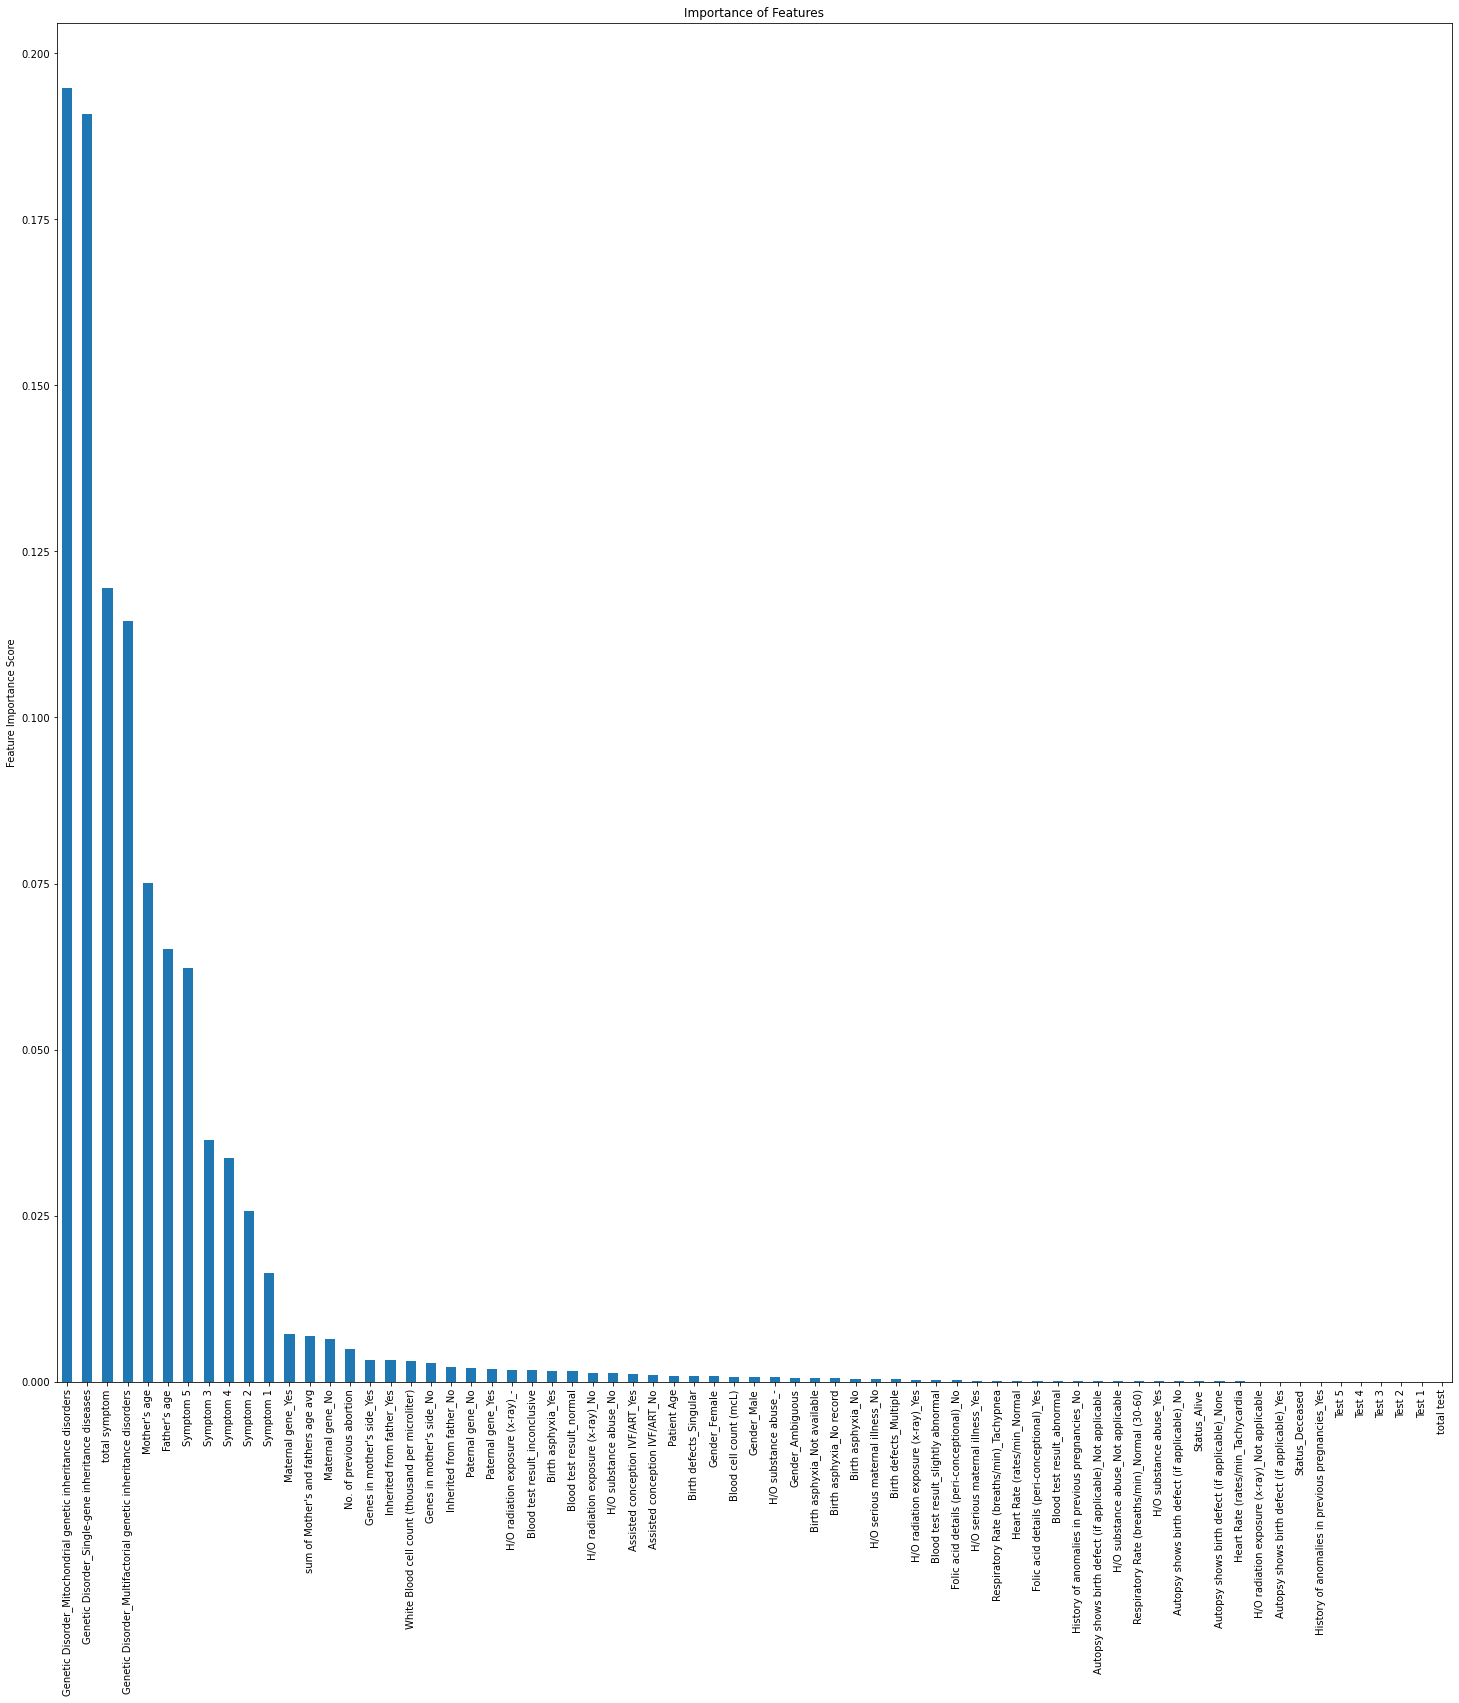

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(25,25))
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test ,pred))


### Run a baseline GradientBoostingClassifier model with hyperparameter tuning

In [27]:
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4, cv=3)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_


({'mean_fit_time': array([ 5.12171936, 12.72332589, 25.95231509, 38.4683849 , 51.64502756,
         64.20837625, 76.66113695,  5.1885461 , 13.06589707, 26.21205537,
         38.56448007, 51.65548968, 64.18837571, 77.63600643,  5.2084651 ,
         13.14692259, 26.11484098, 39.63849155, 54.3701427 , 65.17792296,
         77.04726895,  5.20541803, 12.94079534, 26.24451979, 38.74611497,
         51.58075086, 64.68422993, 78.15260927,  5.11729209, 12.90329035,
         25.77813864, 39.26534112, 53.42926208, 65.72897164, 79.01998774,
          5.18794338, 13.29133312, 26.48566508, 40.39846921, 52.9989903 ,
         65.10854197, 77.19518002]),
  'std_fit_time': array([0.00431616, 0.00903454, 0.06427474, 0.22868874, 0.11575235,
         0.11696307, 0.14595001, 0.03573649, 0.13549678, 0.08944163,
         0.04957734, 0.01645154, 0.28264249, 0.14169873, 0.08481634,
         0.08248566, 0.18533891, 0.40584546, 0.40299793, 1.008284  ,
         0.11071728, 0.07376788, 0.17628924, 0.0869815 , 0.035

### Tuning Max Depth

In [36]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1500, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,cv=3)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_


({'mean_fit_time': array([ 51.17971102,  64.24432079,  78.23057826,  94.96155   ,
         117.02257005, 139.29439855]),
  'std_fit_time': array([0.03968965, 0.15330074, 0.51540989, 0.540389  , 0.2310035 ,
         3.58414357]),
  'mean_score_time': array([0.70599405, 0.99766946, 1.3125697 , 1.84538492, 2.13277284,
         2.42539676]),
  'std_score_time': array([0.00328072, 0.00469685, 0.02312121, 0.18449517, 0.02829362,
         0.06341725]),
  'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 2},
   {'max_depth': 3},
   {'max_depth': 4},
   {'max_depth': 5},
   {'max_depth': 6},
   {'max_depth': 7}],
  'split0_test_score': array([0.87547075, 0.8842581 , 0.8865177 , 0.88099423, 0.87622395,
         0.87446648]),
  'split1_test_score': array([0.87798142, 0.88701983, 0.8850113 , 0.88827517, 0.88224956,
         0.8857645 ]),
  'split2_

### First evaluation of new model

Accuracy of the GBM on test set: 0.888
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       690
         1.0       0.94      0.90      0.92       114
         2.0       0.96      1.00      0.98       352
         3.0       0.84      0.86      0.85      1030
         4.0       1.00      1.00      1.00        17
         5.0       0.85      0.94      0.89       561
         6.0       0.91      0.70      0.79       276
         7.0       0.85      0.83      0.84       912
         8.0       1.00      0.52      0.68        31

    accuracy                           0.89      3983
   macro avg       0.93      0.86      0.88      3983
weighted avg       0.89      0.89      0.89      3983



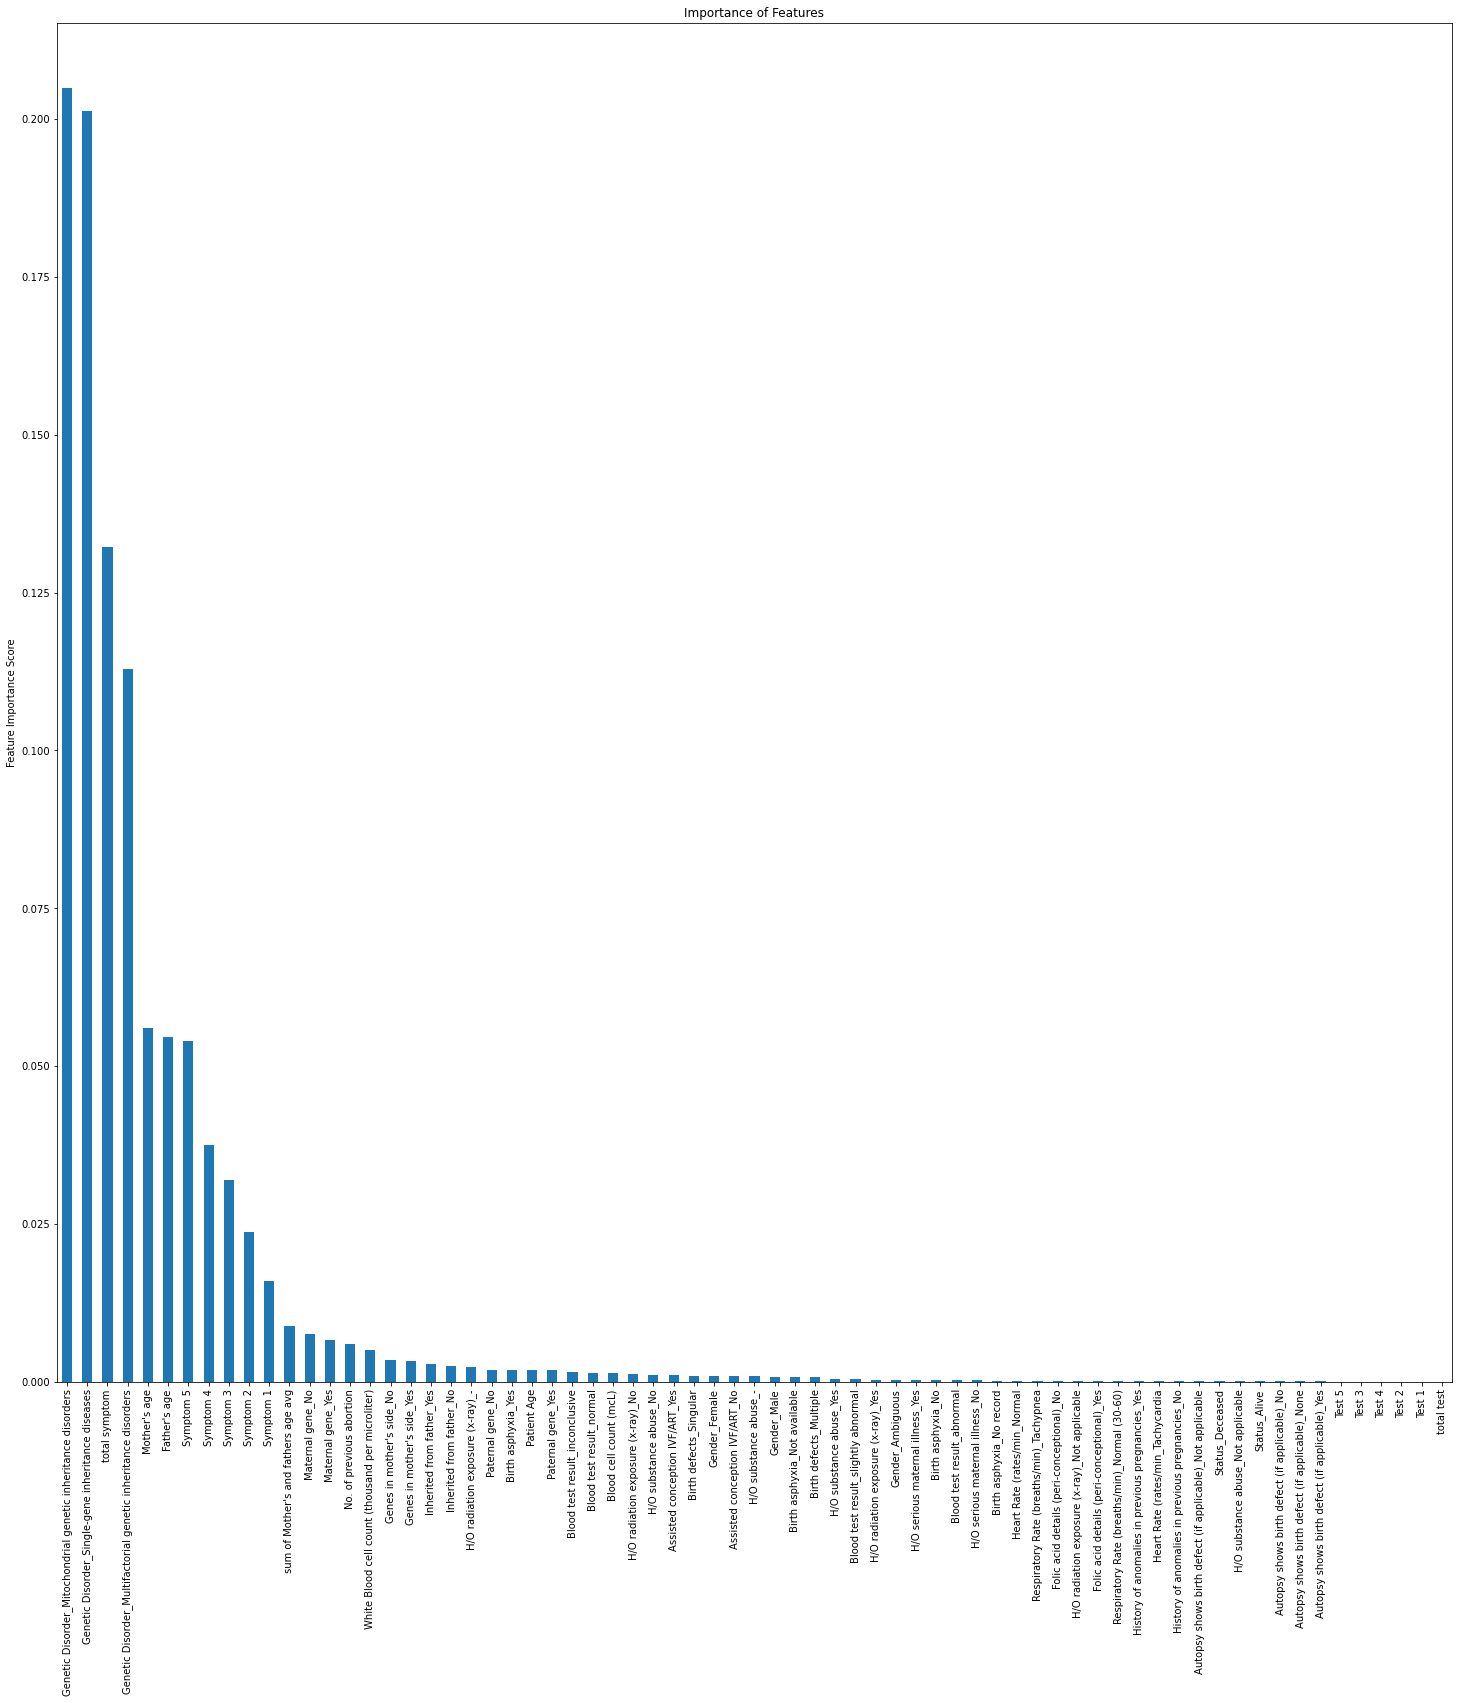

In [37]:
import matplotlib.pyplot as plt
model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(25,25))
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(X_test, y_test)))
pred=model1.predict(X_test)
print(classification_report(y_test, pred))

### Gradient Boosting Classifier with Cross Validation (k=10)

In [94]:
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
kfold = model_selection.KFold(n_splits=10)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 88.71% (0.65%)


### Ensemble Model with Cross Validation

In [95]:
from sklearn.ensemble import VotingClassifier
kfold = model_selection.KFold(n_splits=10)

model_1 = LogisticRegression(solver="newton-cg")
model_2 = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, 
                        learning_rate = 0.3,max_depth = 5, alpha = 10, n_estimators = 10)
model_3 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', bootstrap=False, random_state = 42)
model_4 = GradientBoostingClassifier(verbose=False,learning_rate = 0.15, random_state=35)
model_5 = SVC(kernel='linear', C=1)
model_6 = DecisionTreeClassifier(criterion = "gini", random_state = 1300, max_depth=1500, min_samples_leaf=5)
model_7 = MLPClassifier(hidden_layer_sizes=(20, 12, 20, 15), activation='tanh', solver='adam', 
                    alpha=0.0001, learning_rate='adaptive', 
                    learning_rate_init=0.0001, power_t=0.5, max_iter=1500, shuffle=True, 
                    random_state=None, verbose=False, warm_start=False, 
                    momentum=0.9, early_stopping=False, 
                    validation_fraction=0.1, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=2000)

final_model = VotingClassifier(
    estimators=[ ('lr', model_1),('xgb', model_2),('rf', model_3), ('gb', model_4),('svm', model_5),
                ('cart', model_6),('gnb', model_7)])
 
# training all the model on the train dataset
final_model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = final_model.predict(X_val)

score = final_model.score(X_val, y_val)
print('Accuracy Score: ', score)

classification_report(y_val, pred_final)
print(classification_report)

accuracy = accuracy_score(y_val, pred_final)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = model_selection.cross_val_score(final_model, X_train, y_train, cv=kfold)
print(results.mean())

### Tuning n_estimators and Learning rate

[14:11:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score:  0.8576449912126538
<function classification_report at 0x7fb391455790>
Accuracy: 85.76%
[14:12:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost

### Ensemble Model with Hyperparameter Tuning

In [96]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

model_1 = LogisticRegression(solver="newton-cg")
model_2 = XGBClassifier(learning_rate=0.3, booster='gbtree')
model_3 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', bootstrap=False, random_state = 42)
model_4 = GradientBoostingClassifier(verbose=False,learning_rate = 0.15)
model_6 = DecisionTreeClassifier(random_state=42,criterion="gini",splitter="best")
model_5 = SVC(kernel='linear', C=1)
model_7 = MLPClassifier(hidden_layer_sizes=(10,30,10), activation='relu', solver='adam', 
                    alpha=0.0001, learning_rate='adaptive', 
                    learning_rate_init=0.0001, power_t=0.5, max_iter=1500, shuffle=True, 
                    random_state=None, verbose=False, warm_start=False, 
                    momentum=0.9, early_stopping=False, 
                    validation_fraction=0.1, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=2000)

vc = VotingClassifier(
    estimators=[('lr', model_1), ('xgb', model_2), ('rf', model_3), ('gb', model_4),('svm', model_5),
                ('cart', model_6),('gnb', model_7)])

cvm = cross_val_score(vc, X_train, y_train)
base_score = cvm.mean()
base_std = cvm.std()
print('\n')
print(f'The average base cross-validation score is {round(base_score,4)} (+- {round(base_std,4)})')

params = {'voting':['hard', 'soft'],
          'weights':[(1,1,1,1,1,1,1), (2,1,1,1,1,2,1), 
                     (1,2,1,1,1,1,2), (1,1,2,1,1,1,2),
                     (1,1,1,2,1,2,1), (1,1,1,1,2,1,1), 
                     (1,1,1,2,2,1,1), (2,1,1,1,2,1,2)]}

#fit gridsearch & print best params
grid = GridSearchCV(vc, params)
grid.fit(X_train, y_train)
print('\n')
print(f'The best params is : {grid.best_params_}')

#print the final cv score
tuned_vc = VotingClassifier([('lr', model_1), ('xgb', model_2), ('rf', model_3), ('gb', model_4),('svm', model_5),
                             ('cart', model_6),('gnb', model_7)], 
                             **grid.best_params_, n_jobs = -1)
tuned_cvm = cross_val_score(tuned_vc, X_train, y_train)
tuned_score = tuned_cvm.mean()
tuned_std = tuned_cvm.std()
print('\n')
print(f'The average tuned cross-validation score is {round(tuned_score, 4)} (+- {round(tuned_std, 4)})')


[14:26:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

# Predicting for test data

### Converting Categorical Data using One Hot Encoding

In [308]:
catecols=["Genes in mother's side", "Inherited from father", 'Maternal gene',
       'Paternal gene','Respiratory Rate (breaths/min)','Heart Rate (rates/min','Birth asphyxia',
       'Autopsy shows birth defect (if applicable)','Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)', 'H/O substance abuse','Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies','Birth defects','Blood test result','Status','Gender']

one_hot_encoded_data = pd.get_dummies(df_test, columns = catecols)

df_test=one_hot_encoded_data
df_test = df_test.apply(pd.to_numeric,downcast="float")
df_test

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,...,Birth defects_Singular,Blood test result_abnormal,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal,Status_Alive,Status_Deceased,Gender_Ambiguous,Gender_Female,Gender_Male
0,6.0,4.981655,38.0,61.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0,0,0,0,1,1,0,0,0,1
1,10.0,5.118889,33.0,53.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0,0,0,1,0,1,0,0,0,1
2,5.0,4.876204,48.0,60.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,1,1,0,0
3,13.0,4.687767,25.0,55.0,0.0,0.0,0.0,1.0,0.0,2.0,...,1,0,0,1,0,1,0,1,0,0
4,5.0,5.152362,41.0,38.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,9.0,4.878335,28.0,63.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0,1,0,0,0,1,0,0,0,1
9461,1.0,4.927151,37.0,62.0,0.0,0.0,0.0,1.0,0.0,2.0,...,1,1,0,0,0,0,1,0,0,1
9462,2.0,4.898352,24.0,32.0,0.0,0.0,0.0,1.0,0.0,3.0,...,1,0,0,1,0,0,1,0,1,0
9463,13.0,4.804840,36.0,56.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,0,1,0,0,1,0,0,1,0


In [309]:
df_test["sum of Mother's and fathers age avg"]=(df_test["Mother's age"]+df_test["Father's age"]) / 2
df_test["total symptom"]=(df_test["Symptom 1"]+df_test["Symptom 2"]+df_test["Symptom 3"]+df_test["Symptom 4"]+df_test["Symptom 5"]) / 5
df_test["total test"]=(df_test["Test 1"]+df_test["Test 2"]+df_test["Test 3"]+df_test["Test 4"]+df_test["Test 5"])/5

### Normalizing the Test Data

In [310]:
sc = MinMaxScaler()
testscaler = sc.fit_transform(df_test[cols_names]) 
df_test[cols_names]=testscaler

In [311]:
df_test

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,...,Blood test result_normal,Blood test result_slightly abnormal,Status_Alive,Status_Deceased,Gender_Ambiguous,Gender_Female,Gender_Male,sum of Mother's and fathers age avg,total symptom,total test
0,6.0,0.553563,38.0,61.0,0.0,0.0,0.0,1.0,0.0,0.50,...,0,1,1,0,0,0,1,49.5,0.2,0.2
1,10.0,0.641776,33.0,53.0,0.0,0.0,0.0,1.0,0.0,0.50,...,1,0,1,0,0,0,1,43.0,0.2,0.2
2,5.0,0.485780,48.0,60.0,0.0,0.0,0.0,1.0,0.0,0.00,...,0,1,0,1,1,0,0,54.0,0.2,0.2
3,13.0,0.364654,25.0,55.0,0.0,0.0,0.0,1.0,0.0,0.50,...,1,0,1,0,1,0,0,40.0,0.2,0.2
4,5.0,0.663292,41.0,38.0,0.0,0.0,0.0,1.0,0.0,0.50,...,1,0,0,1,1,0,0,39.5,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,9.0,0.487149,28.0,63.0,0.0,0.0,0.0,1.0,0.0,0.50,...,0,0,1,0,0,0,1,45.5,0.2,0.2
9461,1.0,0.518528,37.0,62.0,0.0,0.0,0.0,1.0,0.0,0.50,...,0,0,0,1,0,0,1,49.5,0.2,0.2
9462,2.0,0.500016,24.0,32.0,0.0,0.0,0.0,1.0,0.0,0.75,...,1,0,0,1,0,1,0,28.0,0.2,0.2
9463,13.0,0.439907,36.0,56.0,0.0,0.0,0.0,1.0,0.0,0.25,...,0,0,1,0,0,1,0,46.0,0.2,0.2


### Getting the corresponding Disorder subclass of the prediction

In [312]:
d1={}
d1[0]="Cystic fibrosis"
d1[1]="Leber's hereditary optic neuropathy"
d1[2]="Diabetes"
d1[3]="Leigh syndrome"
d1[4]="Cancer"
d1[5]="Tay-Sachs"
d1[6]="Hemochromatosis"
d1[7]="Mitochondrial myopathy"
d1[8]="Alzheimer's"

### Gradient Boosting Classifier with the best hyperparameters obtained after tuning

In [313]:
gbct_m = GradientBoostingClassifier(verbose=False,learning_rate = 0.15, random_state=35).fit(X_train,y_train)

predict = gbct_m.predict(df_test)

In [314]:
predict

array([5., 5., 5., ..., 6., 5., 5.], dtype=float32)

In [315]:
for i in predict:
    df_test['Genetic Disorder']=d[d1[int(i)]]
    df_test['Disorder Subclass']=d1[int(i)]

In [316]:
df_test

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,...,Status_Alive,Status_Deceased,Gender_Ambiguous,Gender_Female,Gender_Male,sum of Mother's and fathers age avg,total symptom,total test,Genetic Disorder,Disorder Subclass
0,6.0,0.553563,38.0,61.0,0.0,0.0,0.0,1.0,0.0,0.50,...,1,0,0,0,1,49.5,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
1,10.0,0.641776,33.0,53.0,0.0,0.0,0.0,1.0,0.0,0.50,...,1,0,0,0,1,43.0,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
2,5.0,0.485780,48.0,60.0,0.0,0.0,0.0,1.0,0.0,0.00,...,0,1,1,0,0,54.0,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
3,13.0,0.364654,25.0,55.0,0.0,0.0,0.0,1.0,0.0,0.50,...,1,0,1,0,0,40.0,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
4,5.0,0.663292,41.0,38.0,0.0,0.0,0.0,1.0,0.0,0.50,...,0,1,1,0,0,39.5,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,9.0,0.487149,28.0,63.0,0.0,0.0,0.0,1.0,0.0,0.50,...,1,0,0,0,1,45.5,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
9461,1.0,0.518528,37.0,62.0,0.0,0.0,0.0,1.0,0.0,0.50,...,0,1,0,0,1,49.5,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
9462,2.0,0.500016,24.0,32.0,0.0,0.0,0.0,1.0,0.0,0.75,...,0,1,0,1,0,28.0,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
9463,13.0,0.439907,36.0,56.0,0.0,0.0,0.0,1.0,0.0,0.25,...,1,0,0,1,0,46.0,0.2,0.2,Single-gene inheritance diseases,Tay-Sachs
